# Calculating NDVI from Landsat 8 imagery without a GIS

The [Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index) is a simple indicator that can be used to assess whether the target, usually a remotely-sensed raster image, contains live green vegetation.  This calculation uses two bands of a remote dataset, the Red and Near-Infrared (NIR) bands.

\begin{align}
NDVI & = \frac{(NIR - Red)}{(NIR + Red)}
\end{align}

For this tutorial, we'll use the NIR and Red bands from a landsat 8 scene above part of the central valley and the Sierra Nevada in California.  We'll be using [Level 1 datasets](https://landsat.usgs.gov/landsat-processing-details), orthorectified, map-projected images containing radiometrically calibrated data. These images can be individually downloaded from a variety of sources including:

* [USGS EarthExplorer](https://earthexplorer.usgs.gov/) (Account required for download)
* [Amazon AWS](https://aws.amazon.com/public-datasets/landsat/)
* [Development Seed "Libra"](https://libra.developmentseed.org)

The specific scene we'll be using is `LC08_L1TP_042034_20170616_20170629_01_T1`, which can be downloaded from AWS at https://landsatonaws.com/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1.  Note that this is an index page that links to the scene's rasters, not the dataset itself.

More information on Landsat collections here: [https://landsat.usgs.gov/landsat-collections](https://landsat.usgs.gov/landsat-collections)

![Preview of our landsat 8 scene](http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_thumb_small.jpg)

### Bands

* Red: Band 4 (name: ``LC08_L1TP_042034_20130605_20170310_01_T1_B4.TIF``)
* Near-Infrared: Band 5 (name: ``LC08_L1TP_042034_20130605_20170310_01_T1_B5.TIF``)

Because of the longevity of the landsat mission and because different sensors on the satellite record data at different resolutions, these bands are individually stored as single-band raster files.  Some other rasters may store multiple bands in the same file.

In [10]:
%matplotlib inline

import rasterio
from matplotlib import pyplot as plt
import numpy

SCENE = 'LC08_L1TP_042034_20170616_20170629_01_T1'
AWS_URL = f'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/{SCENE}'
RED_BAND = f'{AWS_URL}/{SCENE}_B4.TIF'
NIR_BAND = f'{AWS_URL}/{SCENE}_B5.TIF'


def plot(array, label=None):
    """Plot a numpy array with a colorbar."""
    plt.imshow(array)
    plt.colorbar()
    if label is None:
        label = 'Raster {}'.format(array.shape)
    plt.title(label)
    plt.xlabel('Column #')
    plt.ylabel('Row #')

In [16]:
import pprint # Fancy printing

# Open a landsat raster within a python context manager
with rasterio.open(RED_BAND) as raster:
    # View the raster's metadata
    pprint.pprint(raster.meta)
    print(raster)

{'count': 1,
 'crs': CRS({'init': 'epsg:32611'}),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7951,
 'nodata': None,
 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0),
 'width': 7821}
<open DatasetReader name='http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF' mode='r'>


[3, 9, 27, 81]
81


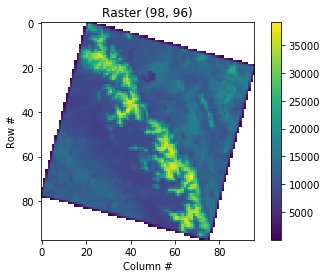

In [20]:
with rasterio.open(RED_BAND) as raster:
    # Read from the raster (will download large file and store as np array)
    #raster_1 = raster.read(1) # Read band 1
    
    # Instead of reading in the whole file, use overviews
    overviews = raster.overviews(1) # Band 1 again
    print(overviews)
    
    # Get the smallest of the overview images
    smallest_overviews = overviews[-1]
    print(smallest_overviews)
    
    # Raster.read this "//" is integer division (casts float to int like math.floor)
    thumbnail = raster.read(1, out_shape=(1, raster.height // smallest_overviews, raster.width // smallest_overviews))
    
    # Use numpy to mask out pixels == 0 as NaN
    thumbnail = thumbnail.astype(numpy.float)
    thumbnail[thumbnail == 0] = numpy.NaN
    
    # Plot this thumbnail overview image
    plot(thumbnail)

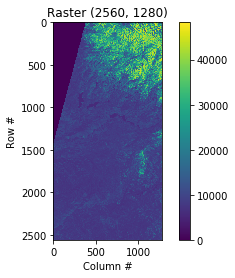

In [5]:
import rasterio.windows

# Open only a window (subset) of the full file
with rasterio.open(RED_BAND) as raster:
    subset = raster.read(1, window=rasterio.windows.Window(1024, 1024, 1280, 2560))
    plot(subset)

In [6]:
from rasterio import Affine

with rasterio.open(RED_BAND) as raster:
    # Get and print the affine transformation matrix
    transform = raster.transform
    pprint.pprint(transform)

    # Update the affine transformation by scaling
    new_transform = transform * Affine.scale(9, 9)
    pprint.pprint(new_transform)

Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0)
Affine(270.0, 0.0, 204285.0,
       0.0, -270.0, 4268115.0)


In [7]:
with rasterio.open(RED_BAND) as raster:
    profile = raster.meta.copy() # can also use raster.profile, make a copy of the dictionary
    overview_factor = raster.overviews(1)[1]
    pixel_values = raster.read(1, out_shape=(1, raster.height // overview_factor, raster.width // overview_factor))
    
    # Update the profile to match overview (add and update key:value pairs)
    profile.update({
        'dtype' : 'float32',
        'height' : raster.height // overview_factor,
        'width' : raster.width // overview_factor,
        'transform' : transform * Affine.scale(9, 9)
    })
    
    with rasterio.open('red_downsized.tif', 'w', **profile) as dest_raster:
        dest_raster.write(1, pixel_values) # Write the new raster, band 1

AttributeError: 'int' object has no attribute 'shape'

Text(0,0.5,'Row #')

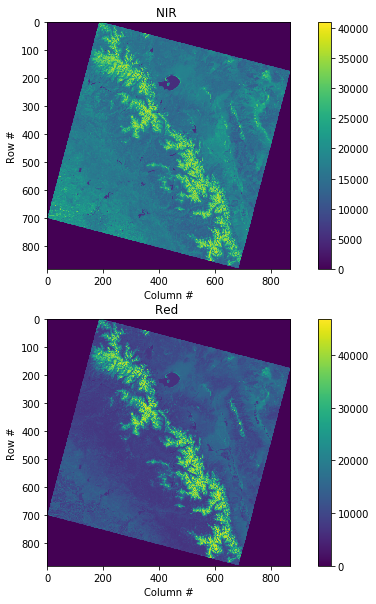

In [27]:
import rasterio.plot

plt.figure(0,figsize=(10,10))

with rasterio.open(NIR_BAND) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.subplot(211)
plt.imshow(nir)
plt.colorbar()
plt.title('NIR {}'.format("", nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')




with rasterio.open(RED_BAND) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.subplot(212)
plt.imshow(red)
plt.colorbar()
plt.title('Red {}'.format("", red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0,0.5,'Row #')

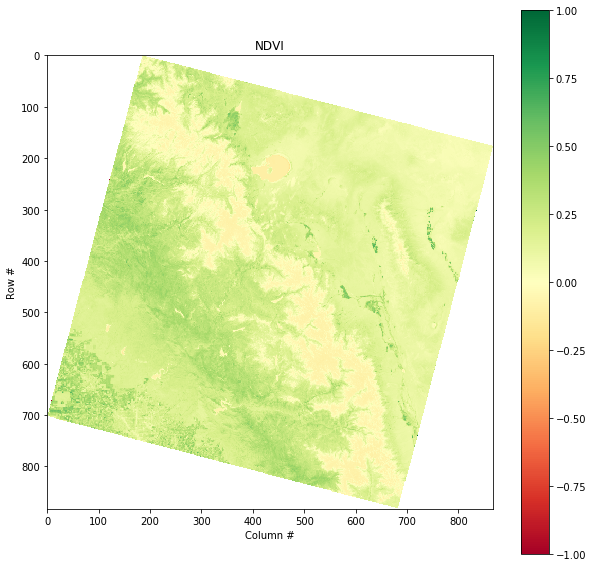

In [36]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

plt.figure(0,figsize=(10,10))
ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')


#rasterio.open("newfile.tif", 'w', driver='GTiff', height=data_array.shape[0],
#                       width=data_array.shape[1], count=1, dtype=data_array.dtype,
#                       crs=original_image.crs, transform=original_image.transform)
#

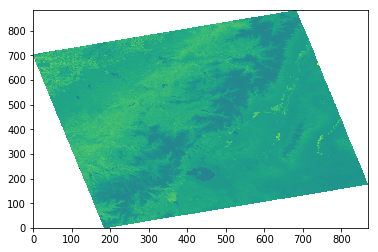

In [44]:
plt.pcolor(ndvi);